In [1]:
from copy import deepcopy
from tools import *
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
def load_data():
    import json
    rv = list()
    for filename in [
        'results/2020-03-05T10:25:58.411328-05:00.json',
        'results/2020-03-07T11:49:11.708548-05:00.json',
        'results/2020-03-08T20:23:53.739182-04:00.json']:
        with open(filename, 'r') as infile:
            rv += json.load(infile)

    # clean up data to fit assumptions
    EPS = 1e-9
    for entry in rv:
        entry['auc'] = sum(entry['accuracy'])
        entry['lambda_'] = entry['lambda']  # pandas doesn't allow for columns to be called lambda
        del entry['lambda']
        if entry['approximator'] == 'constant':
            entry['optimizer'] = 'constant'  # rest of plotting relies on optimizer being defined
        if (entry['optimizer'] == 'sgd') and (abs(float(entry['momentum'])) > EPS):
            entry['optimizer'] = 'momentum'  # separate sgd with and without momentum

    to_delete = list()
    constant_seeds = set()
    for i in range(len(rv)):
        if rv[i]['rho'] == 0.999:
            to_delete.append(i)
        if rv[i]['approximator'] == 'constant':
            if rv[i]['env_seed'] in constant_seeds:
                to_delete.append(i)
            else:
                constant_seeds.add(rv[i]['env_seed'])
    for i in reversed(to_delete):
        del rv[i]

    # return cleaned data
    return rv

def get_auc_table(data):
    temp = dict()
    for entry in data:
        key = get_hyperparameter_key(entry)
        if key in temp:
            temp[key].append(entry['auc'])
        else:
            temp[key] = [entry['auc']]
    auc_table = list()
    for key, value in temp.items():
        entry = dict(key._asdict())
        entry['count'] = len(value)
        entry['auc_mean'] = np.mean(value)
        entry['auc_stderr'] = np.std(value) / np.sqrt(len(value))
        auc_table.append(entry)
    return pd.DataFrame(list_of_dicts_to_dict_of_lists(auc_table))

def get_best_auc_table(data, auc_table=None):
    if auc_table is None:
        auc_table = get_auc_table(data)
    
    # build best auc table
    auc_table = auc_table[auc_table['rho'] != 0.999]
    best_auc_table = list()
    for optimizer in auc_table['optimizer'].unique():
        sub_table = auc_table[auc_table['optimizer'] == optimizer]
        best_auc_table.append((sub_table.loc[sub_table['auc_mean'].idxmin()]).to_dict())
    return pd.DataFrame(list_of_dicts_to_dict_of_lists(best_auc_table))

def get_best_by_optimizer(data, best_auc_table=None):
    if best_auc_table is None:
        best_auc_table = get_best_auc_table(data, get_auc_table(data))
        
    # build best by optimizer dict
    best_keys = {row['optimizer']: get_hyperparameter_key(row.to_dict()) for _, row in best_auc_table.iterrows()}
    rv = dict()
    for entry in data:
        optimizer = entry['optimizer']
        if get_hyperparameter_key(entry) == best_keys[optimizer]:
            if optimizer not in rv:
                rv[optimizer] = [entry]
            else:
                rv[optimizer].append(entry)
    return rv

def get_best_by_optimizer_summary(data, best_auc_table=None, best_by_optimizer=None):
    if best_auc_table is None:
        best_auc_table = get_best_auc_table(data, get_auc_table(data))
    if best_by_optimizer is None:
        best_by_optimizer = get_best_by_optimizer(data, best_auc_table)
    
    # build best by optimizer summary dict
    rv = {row['optimizer']: row.to_dict() for _, row in best_auc_table.iterrows()}
    for key1 in rv.keys():
        for key2 in result_labels:
            try:
                values = np.array([item[key2] for item in best_by_optimizer[key1]])
                rv[key1][key2 + '_mean'] = np.mean(values, axis=0)
                rv[key1][key2 + '_stderr'] = np.std(values, axis=0) / np.sqrt(values.shape[0])
            except TypeError:
                pass
    return rv

In [3]:
raw_data = load_data()

# Validation Results Table

In [4]:
data = deepcopy(raw_data)
to_delete = list()
for i, entry in enumerate(data):
    if entry['env_seed'] >= 50:
        to_delete.append(i)
for i in reversed(to_delete):
    del data[i]
auc_table = get_auc_table(data)
best_auc_table = get_best_auc_table(data, auc_table)
best_by_optimizer = get_best_by_optimizer(data, best_auc_table)
best_by_optimizer_summary = get_best_by_optimizer_summary(data, best_auc_table, best_by_optimizer)

In [5]:
best_auc_table.head(n=10)

,approximator,beta_1,beta_2,lambda_,loss,lr,momentum,optimizer,rho,target_update,count,auc_mean,auc_stderr
0,neural_network,NaN,NaN,None,TD,0.000122,0.81,momentum,NaN,1.0,50,17392.993333,65.882244
1,neural_network,NaN,NaN,None,TD,0.000061,NaN,rms,0.99,1.0,50,24119.047152,50.905453
2,constant,NaN,NaN,None,None,NaN,NaN,constant,NaN,NaN,50,19725.857984,3.167172
3,neural_network,NaN,NaN,None,TD,0.000488,0.00,sgd,NaN,1.0,50,17762.734709,67.549363
4,neural_network,0.9,0.999,None,TD,0.031250,NaN,adam,NaN,1.0,50,17164.717171,104.527487


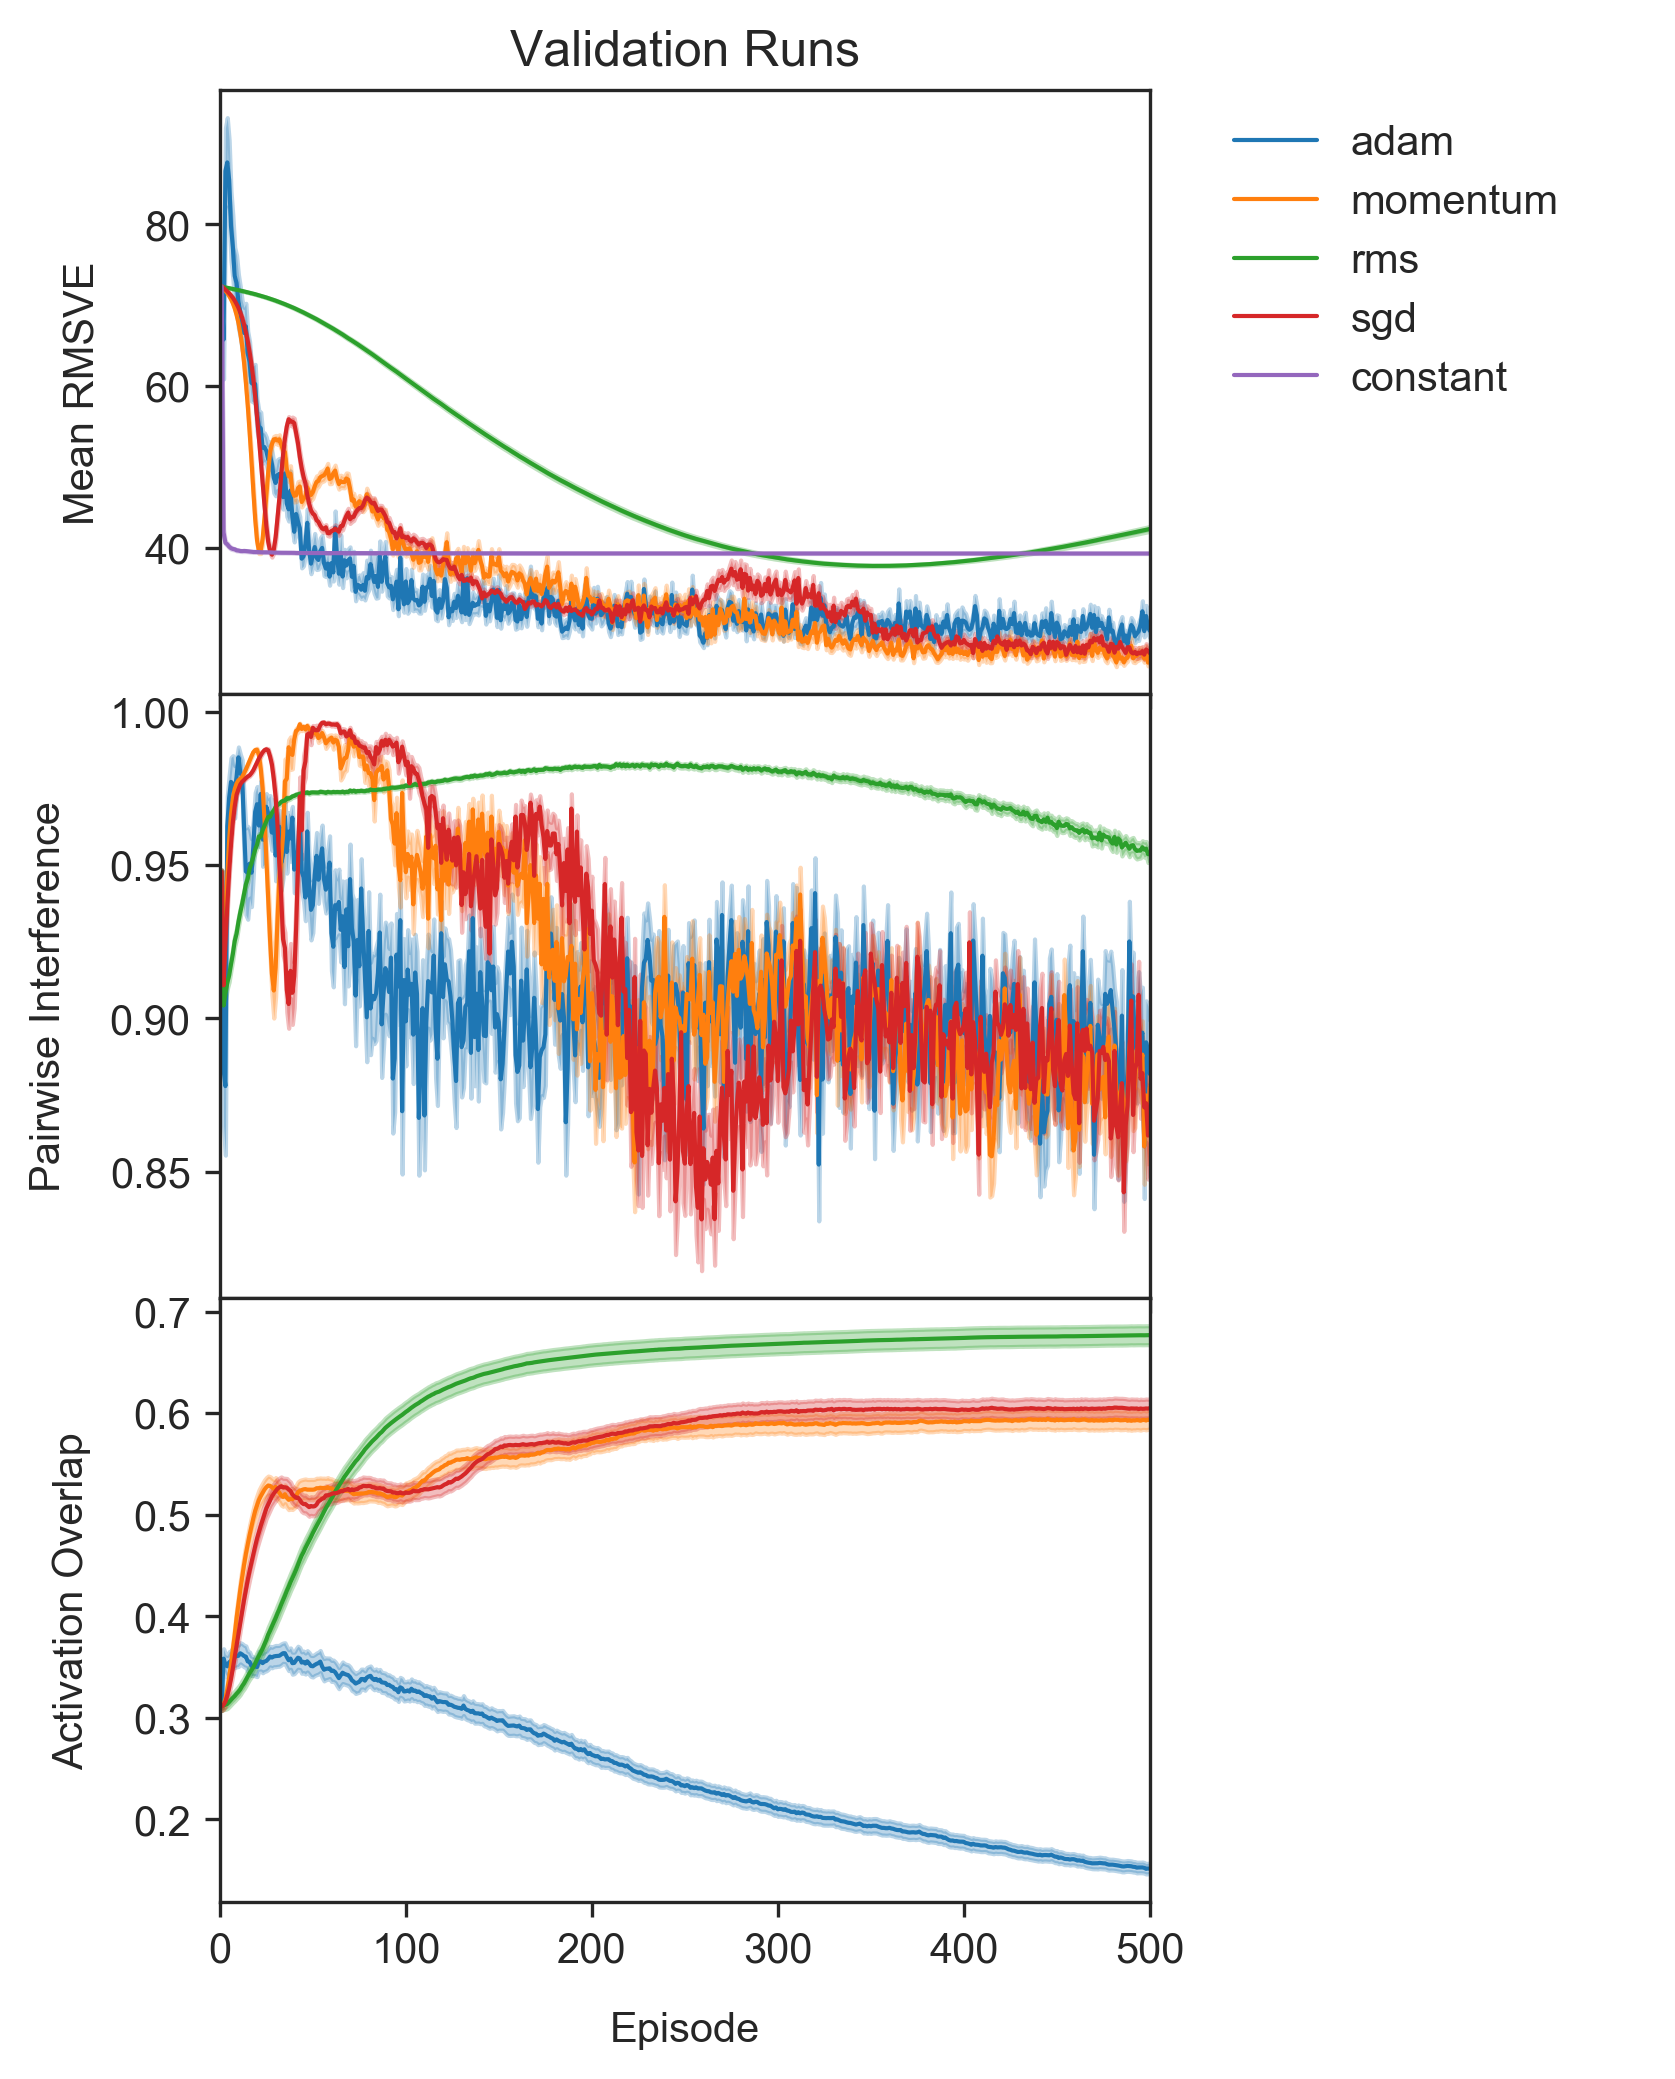

In [6]:
sns.set_style('ticks')
colors = sns.color_palette(n_colors=len(best_by_optimizer_summary.keys()))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, dpi=300, figsize=(4, 8))
sort_key = lambda x: '~' if x[0] == 'constant' else x[0]
for i, (optimizer, value) in enumerate(sorted(best_by_optimizer_summary.items(), key=sort_key)):
    y1 = value['accuracy_mean']
    y1err = value['accuracy_stderr']
    x = np.arange(len(y1)) + 1
    ax1.plot(
        x,
        y1,
        label=optimizer,
        linewidth=1,
        color=colors[i])
    ax1.fill_between(
        x,
        y1 - y1err,
        y1 + y1err,
        alpha=0.3,
        color=colors[i])
    try:
        y2 = value['pairwise_interference_mean']
        y2err = value['pairwise_interference_stderr']
        ax2.plot(
            x,
            y2,
            linewidth=1,
            color=colors[i])
        ax2.fill_between(
            x,
            y2 - y2err,
            y2 + y2err,
            alpha=0.3,
            color=colors[i])
    except KeyError:
        pass
    try:
        y3 = value['activation_overlap_mean']
        y3err = value['activation_overlap_stderr']
        ax3.plot(
            x,
            y3,
            linewidth=1,
            color=colors[i])
        ax3.fill_between(
            x,
            y3 - y3err,
            y3 + y3err,
            alpha=0.3,
            color=colors[i])
    except KeyError:
        pass
ax1.set_title('Validation Runs')
ax1.set_ylabel('Mean RMSVE', labelpad=10)
ax2.set_ylabel('Pairwise Interference', labelpad=10)
ax3.set_ylabel('Activation Overlap', labelpad=10)
ax3.set_xlim(0, 500)
ax3.set_xlabel('Episode', labelpad=10)
fig.legend(loc='upper right', bbox_to_anchor=(1.33, 0.83), frameon=False)
fig.subplots_adjust(hspace=0.0)
fig.savefig('validation_results.png', bbox_inches='tight')

# Test Results Table

In [7]:
data = deepcopy(raw_data)
to_delete = list()
for i, entry in enumerate(data):
    if entry['env_seed'] < 50:
        to_delete.append(i)
for i in reversed(to_delete):
    del data[i]
auc_table = get_auc_table(data)
best_auc_table = get_best_auc_table(data, auc_table)
best_by_optimizer = get_best_by_optimizer(data, best_auc_table)
best_by_optimizer_summary = get_best_by_optimizer_summary(data, best_auc_table, best_by_optimizer)

In [8]:
best_auc_table.head(n=10)

,approximator,beta_1,beta_2,lambda_,loss,lr,momentum,optimizer,rho,target_update,count,auc_mean,auc_stderr
0,neural_network,0.9,0.999,None,TD,0.031250,NaN,adam,NaN,1.0,200,17042.034189,45.297710
1,neural_network,NaN,NaN,None,TD,0.000122,0.81,momentum,NaN,1.0,200,17304.970548,29.483823
2,constant,NaN,NaN,None,None,NaN,NaN,constant,NaN,NaN,200,19721.224639,0.968976
3,neural_network,NaN,NaN,None,TD,0.000488,0.00,sgd,NaN,1.0,200,17890.139904,37.632715
4,neural_network,NaN,NaN,None,TD,0.000061,NaN,rms,0.99,1.0,200,24187.861518,21.057343


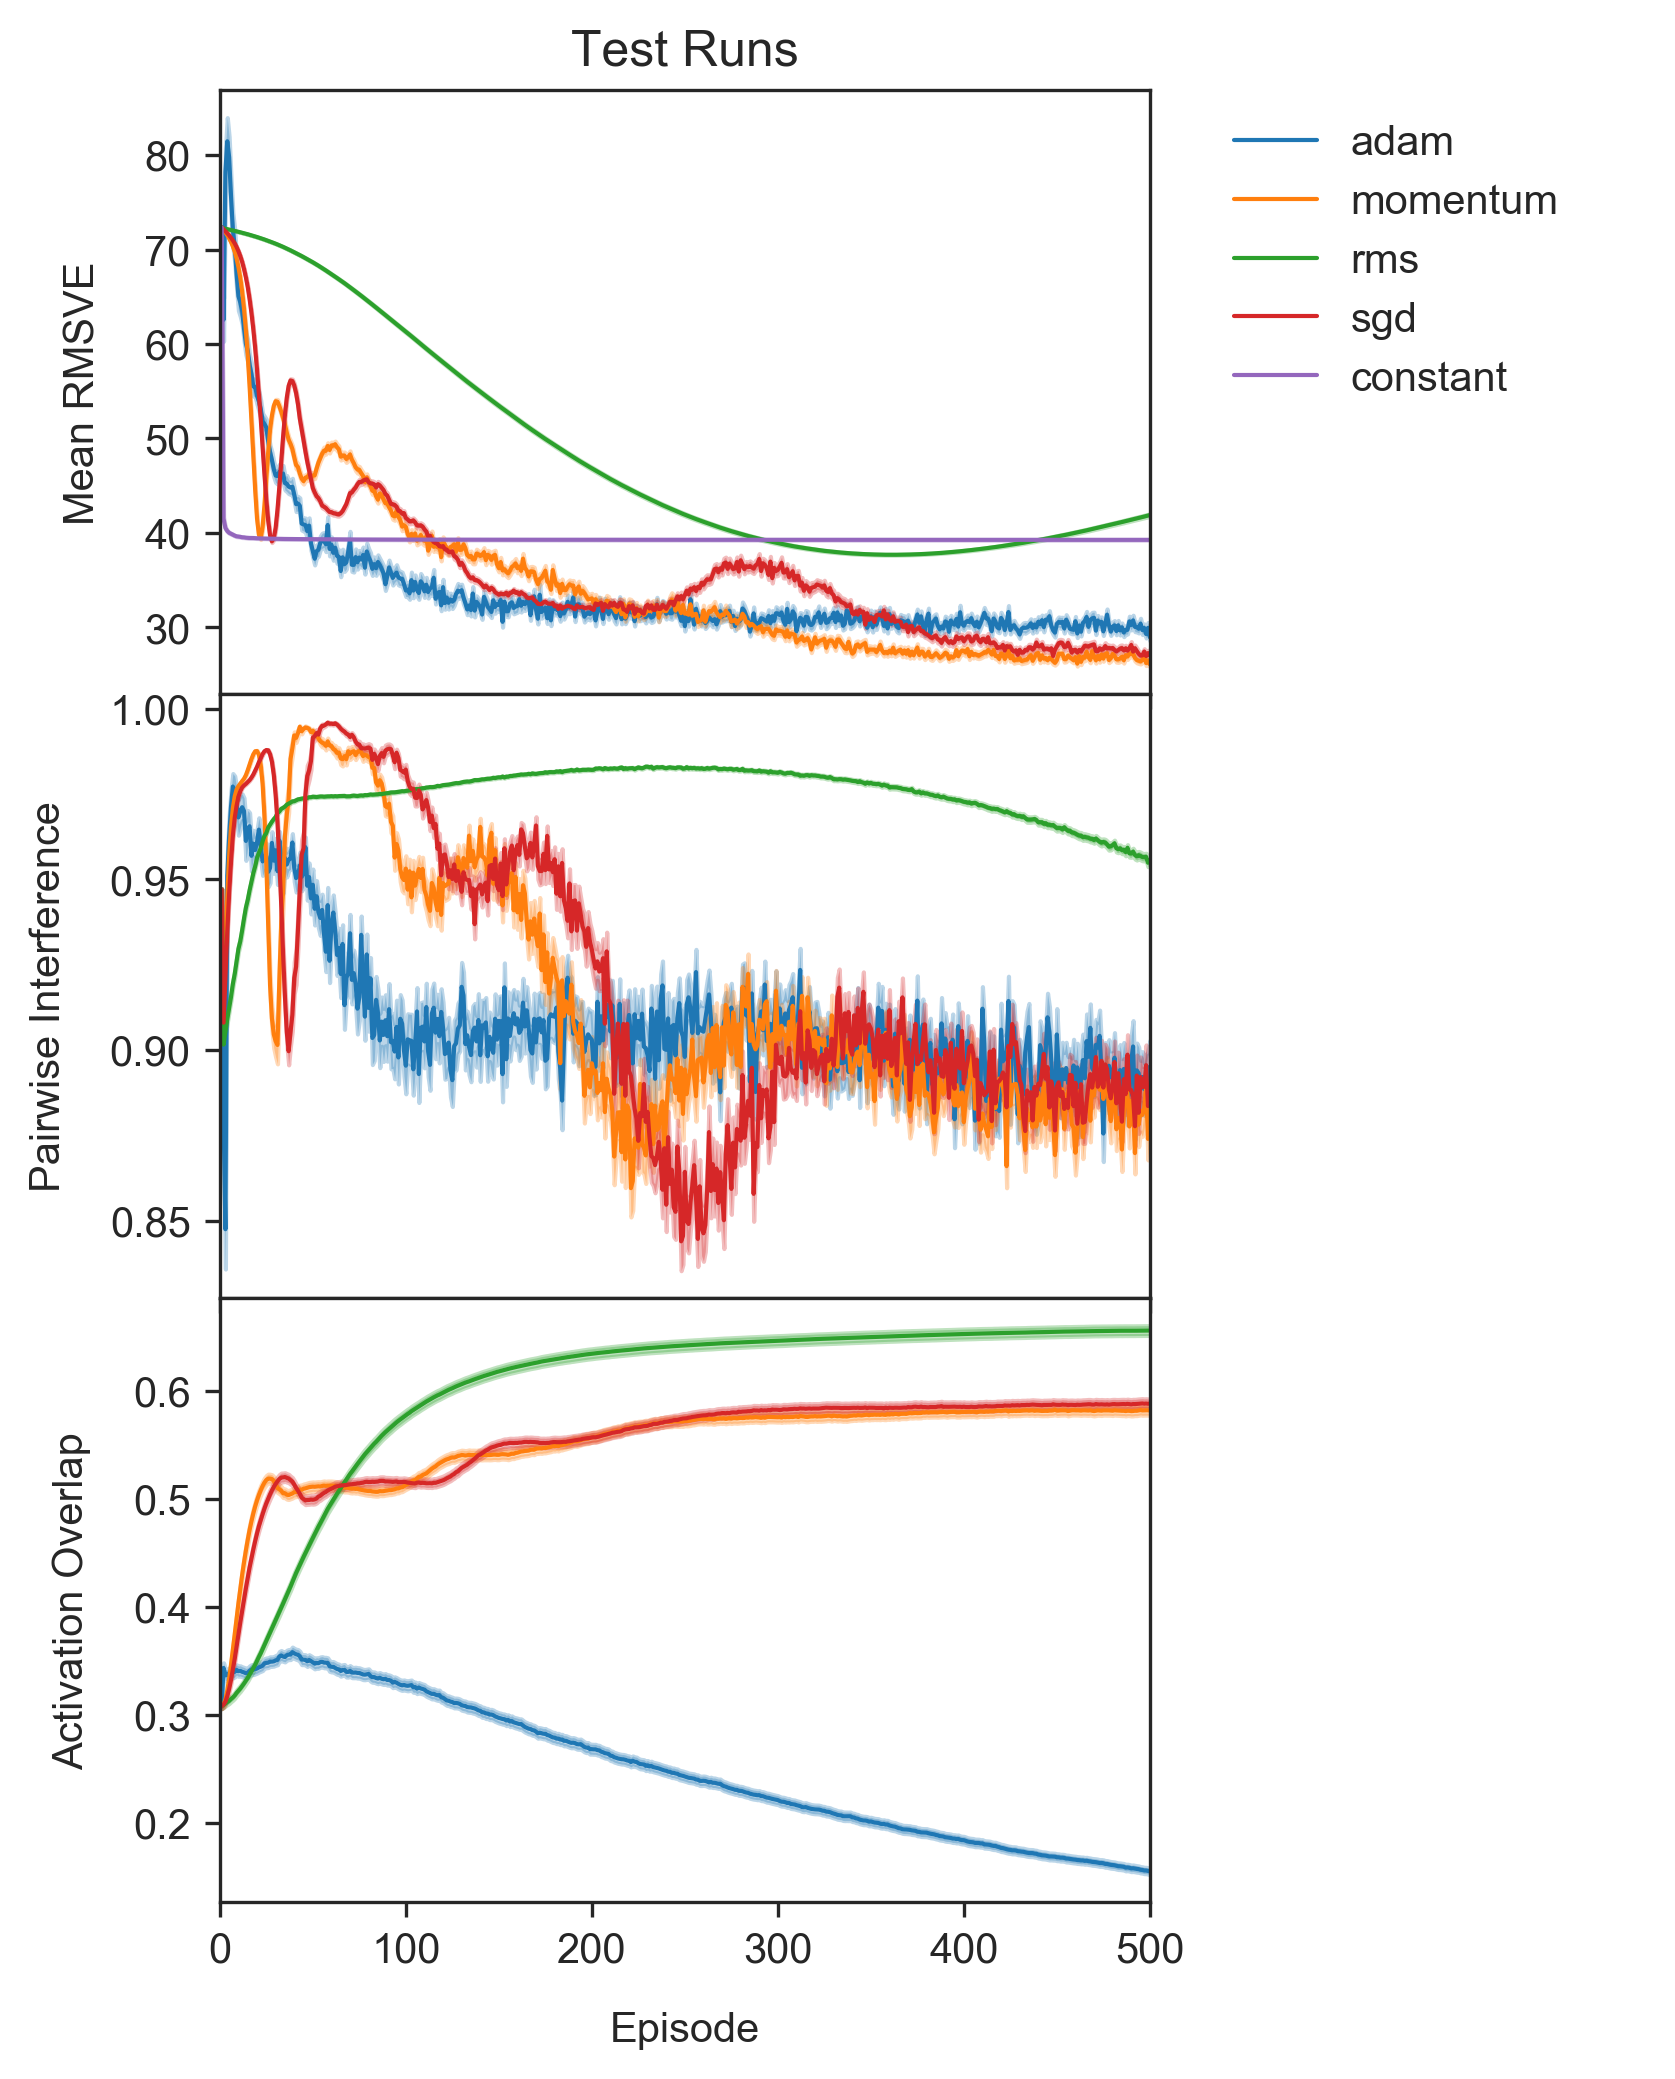

In [9]:
sns.set_style('ticks')
colors = sns.color_palette(n_colors=len(best_by_optimizer_summary.keys()))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, dpi=300, figsize=(4, 8))
sort_key = lambda x: '~' if x[0] == 'constant' else x[0]
for i, (optimizer, value) in enumerate(sorted(best_by_optimizer_summary.items(), key=sort_key)):
    y1 = value['accuracy_mean']
    y1err = value['accuracy_stderr']
    x = np.arange(len(y1)) + 1
    ax1.plot(
        x,
        y1,
        label=optimizer,
        linewidth=1,
        color=colors[i])
    ax1.fill_between(
        x,
        y1 - y1err,
        y1 + y1err,
        alpha=0.3,
        color=colors[i])
    try:
        y2 = value['pairwise_interference_mean']
        y2err = value['pairwise_interference_stderr']
        ax2.plot(
            x,
            y2,
            linewidth=1,
            color=colors[i])
        ax2.fill_between(
            x,
            y2 - y2err,
            y2 + y2err,
            alpha=0.3,
            color=colors[i])
    except KeyError:
        pass
    try:
        y3 = value['activation_overlap_mean']
        y3err = value['activation_overlap_stderr']
        ax3.plot(
            x,
            y3,
            linewidth=1,
            color=colors[i])
        ax3.fill_between(
            x,
            y3 - y3err,
            y3 + y3err,
            alpha=0.3,
            color=colors[i])
    except KeyError:
        pass
ax1.set_title('Test Runs')
ax1.set_ylabel('Mean RMSVE', labelpad=10)
ax2.set_ylabel('Pairwise Interference', labelpad=10)
ax3.set_ylabel('Activation Overlap', labelpad=10)
ax3.set_xlim(0, 500)
ax3.set_xlabel('Episode', labelpad=10)
fig.legend(loc='upper right', bbox_to_anchor=(1.33, 0.83), frameon=False)
fig.subplots_adjust(hspace=0.0)
fig.savefig('test_results.png', bbox_inches='tight')

# SGD with Momentum Results Table

In [10]:
data = deepcopy(raw_data)
to_delete = list()
for i, entry in enumerate(data):
    if entry['optimizer'] != 'momentum':
        to_delete.append(i)
    else:
        entry['optimizer'] = entry['momentum']
for i in reversed(to_delete):
    del data[i]
auc_table = get_auc_table(data)
best_auc_table = get_best_auc_table(data, auc_table)
best_by_optimizer = get_best_by_optimizer(data, best_auc_table)
best_by_optimizer_summary = get_best_by_optimizer_summary(data, best_auc_table, best_by_optimizer)

In [11]:
best_auc_table.head(n=10)

,approximator,beta_1,beta_2,lambda_,loss,lr,momentum,optimizer,rho,target_update,count,auc_mean,auc_stderr
0,neural_network,None,None,None,TD,0.000061,0.90,0.90,None,1,50,17476.002535,64.786290
1,neural_network,None,None,None,TD,0.000004,0.99,0.99,None,1,50,21135.782683,267.404518
2,neural_network,None,None,None,TD,0.000122,0.81,0.81,None,1,250,17322.575105,27.109534


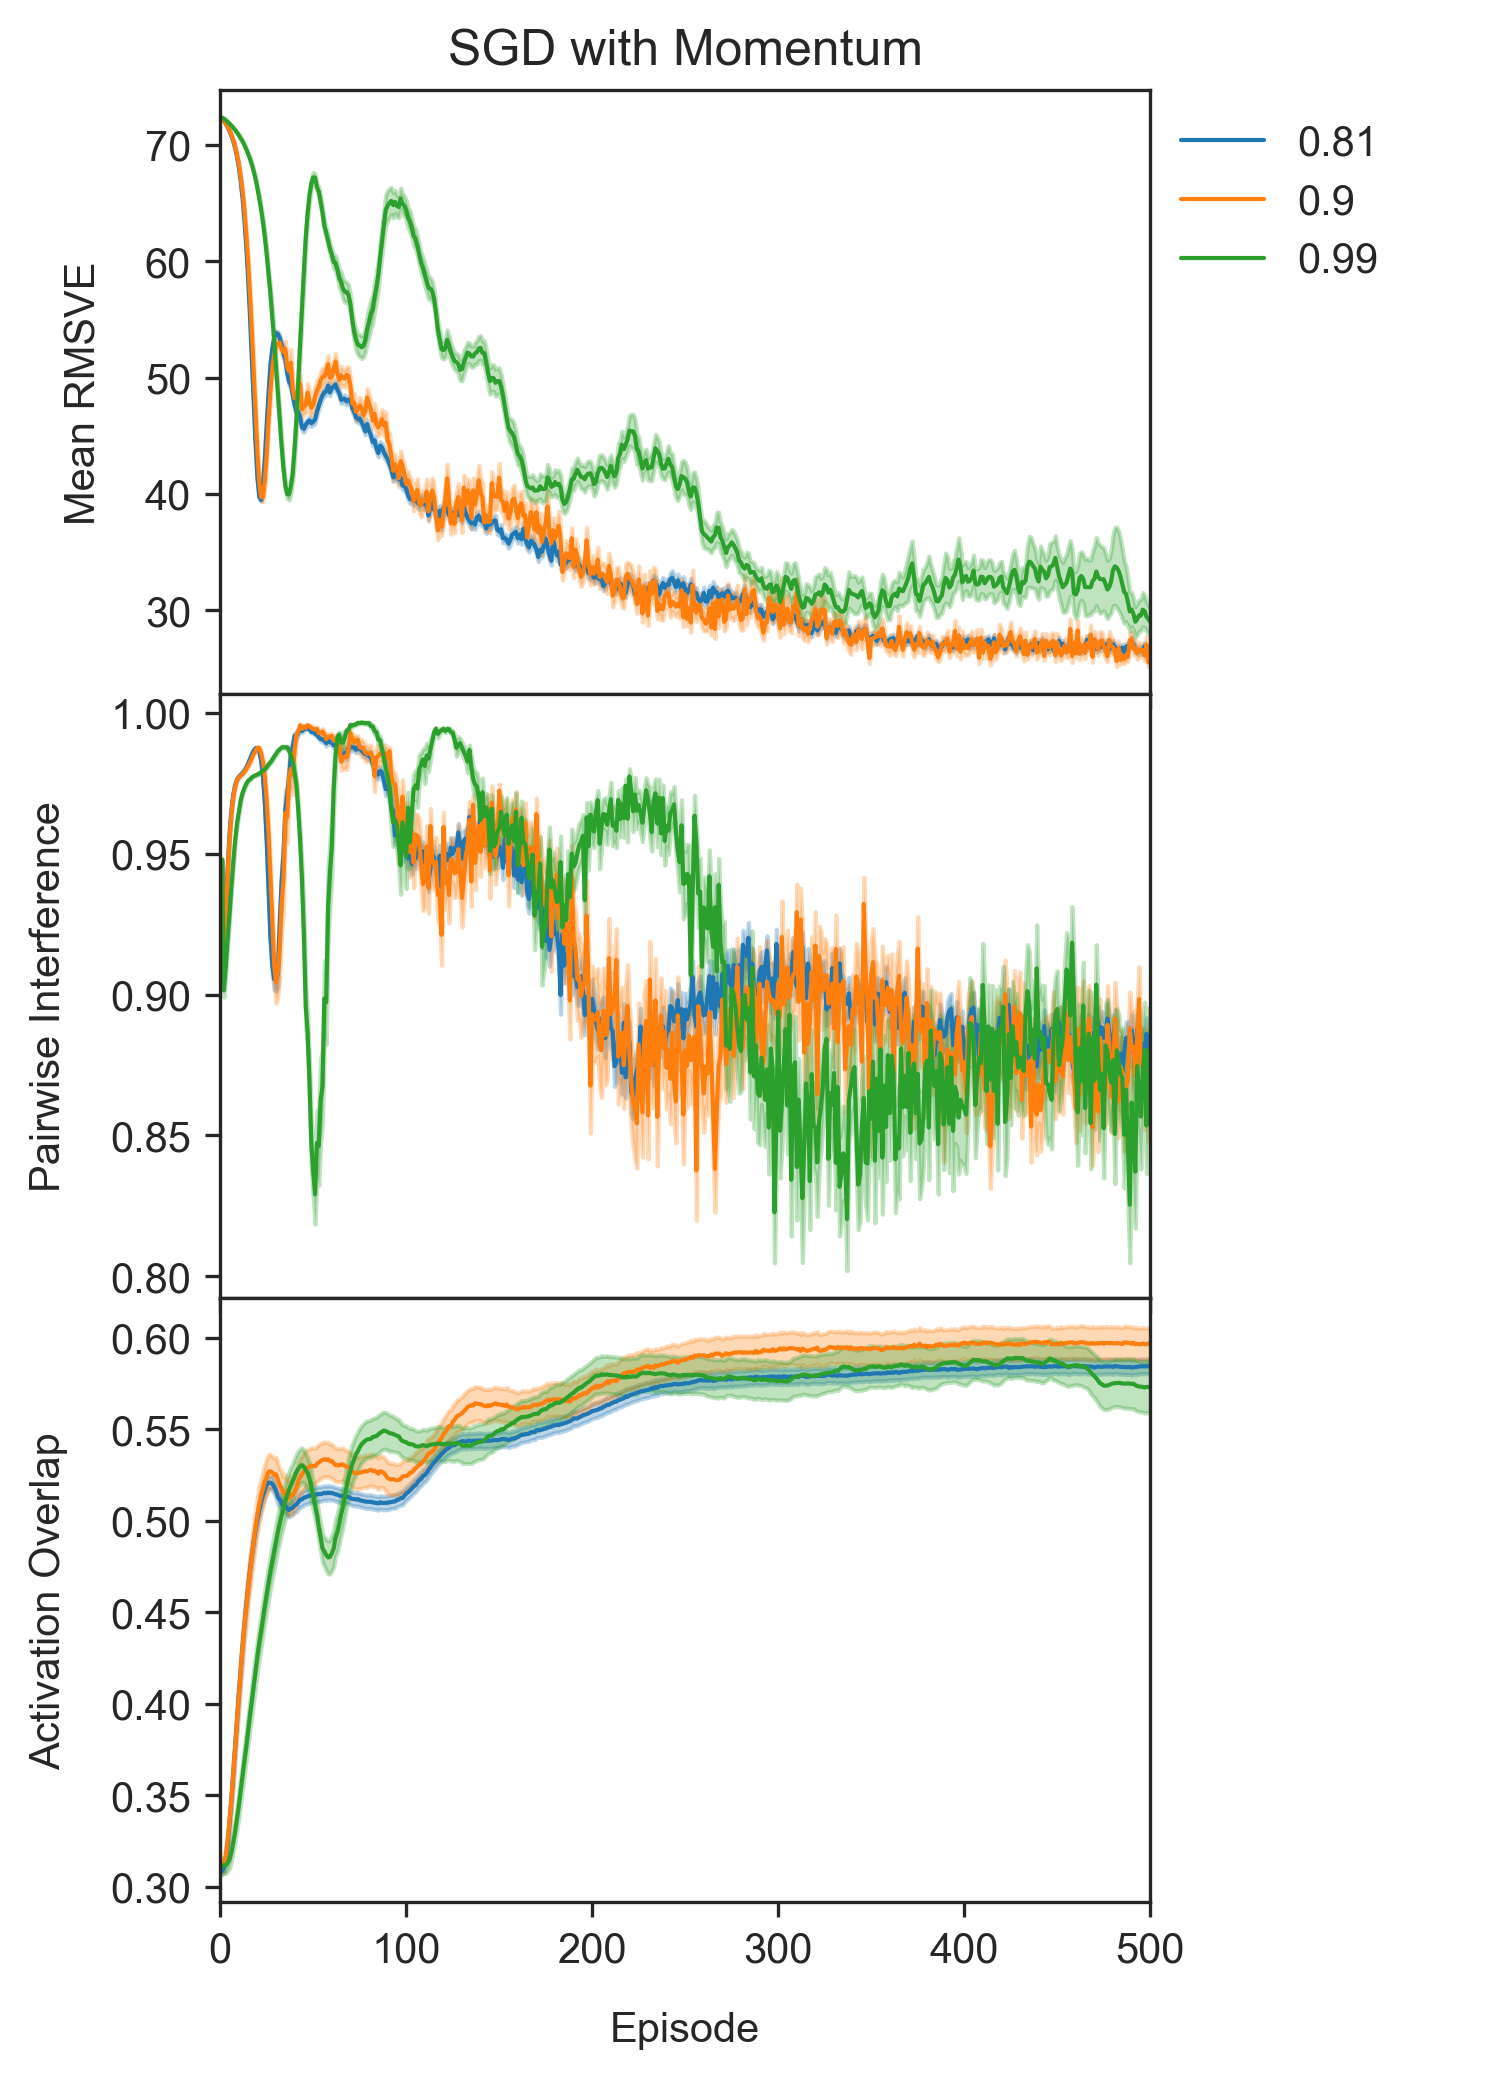

In [12]:
sns.set_style('ticks')
colors = sns.color_palette(n_colors=len(best_by_optimizer_summary.keys()))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, dpi=300, figsize=(4, 8))
sort_key = lambda x: '~' if x[0] == 'constant' else x[0]
for i, (optimizer, value) in enumerate(sorted(best_by_optimizer_summary.items(), key=sort_key)):
    y1 = value['accuracy_mean']
    y1err = value['accuracy_stderr']
    x = np.arange(len(y1)) + 1
    ax1.plot(
        x,
        y1,
        label=optimizer,
        linewidth=1,
        color=colors[i])
    ax1.fill_between(
        x,
        y1 - y1err,
        y1 + y1err,
        alpha=0.3,
        color=colors[i])
    try:
        y2 = value['pairwise_interference_mean']
        y2err = value['pairwise_interference_stderr']
        ax2.plot(
            x,
            y2,
            linewidth=1,
            color=colors[i])
        ax2.fill_between(
            x,
            y2 - y2err,
            y2 + y2err,
            alpha=0.3,
            color=colors[i])
    except KeyError:
        pass
    try:
        y3 = value['activation_overlap_mean']
        y3err = value['activation_overlap_stderr']
        ax3.plot(
            x,
            y3,
            linewidth=1,
            color=colors[i])
        ax3.fill_between(
            x,
            y3 - y3err,
            y3 + y3err,
            alpha=0.3,
            color=colors[i])
    except KeyError:
        pass
ax1.set_title('SGD with Momentum')
ax1.set_ylabel('Mean RMSVE', labelpad=10)
ax2.set_ylabel('Pairwise Interference', labelpad=10)
ax3.set_ylabel('Activation Overlap', labelpad=10)
ax3.set_xlim(0, 500)
ax3.set_xlabel('Episode', labelpad=10)
fig.legend(loc='upper right', bbox_to_anchor=(1.18, 0.83), frameon=False)
fig.subplots_adjust(hspace=0.0)
fig.savefig('momentum_results.png', bbox_inches='tight')

# RMSProp Results Table

In [13]:
data = deepcopy(raw_data)
to_delete = list()
for i, entry in enumerate(data):
    if entry['optimizer'] != 'rms':
        to_delete.append(i)
    else:
        entry['optimizer'] = entry['rho']
for i in reversed(to_delete):
    del data[i]
auc_table = get_auc_table(data)
best_auc_table = get_best_auc_table(data, auc_table)
best_by_optimizer = get_best_by_optimizer(data, best_auc_table)
best_by_optimizer_summary = get_best_by_optimizer_summary(data, best_auc_table, best_by_optimizer)

In [14]:
best_auc_table.head(n=10)

,approximator,beta_1,beta_2,lambda_,loss,lr,momentum,optimizer,rho,target_update,count,auc_mean,auc_stderr
0,neural_network,None,None,None,TD,0.000061,None,0.90,0.90,1,50,27730.405100,148.317440
1,neural_network,None,None,None,TD,0.000061,None,0.99,0.99,1,250,24174.098645,19.760282
2,neural_network,None,None,None,TD,0.000031,None,0.81,0.81,1,50,28102.008920,81.426387


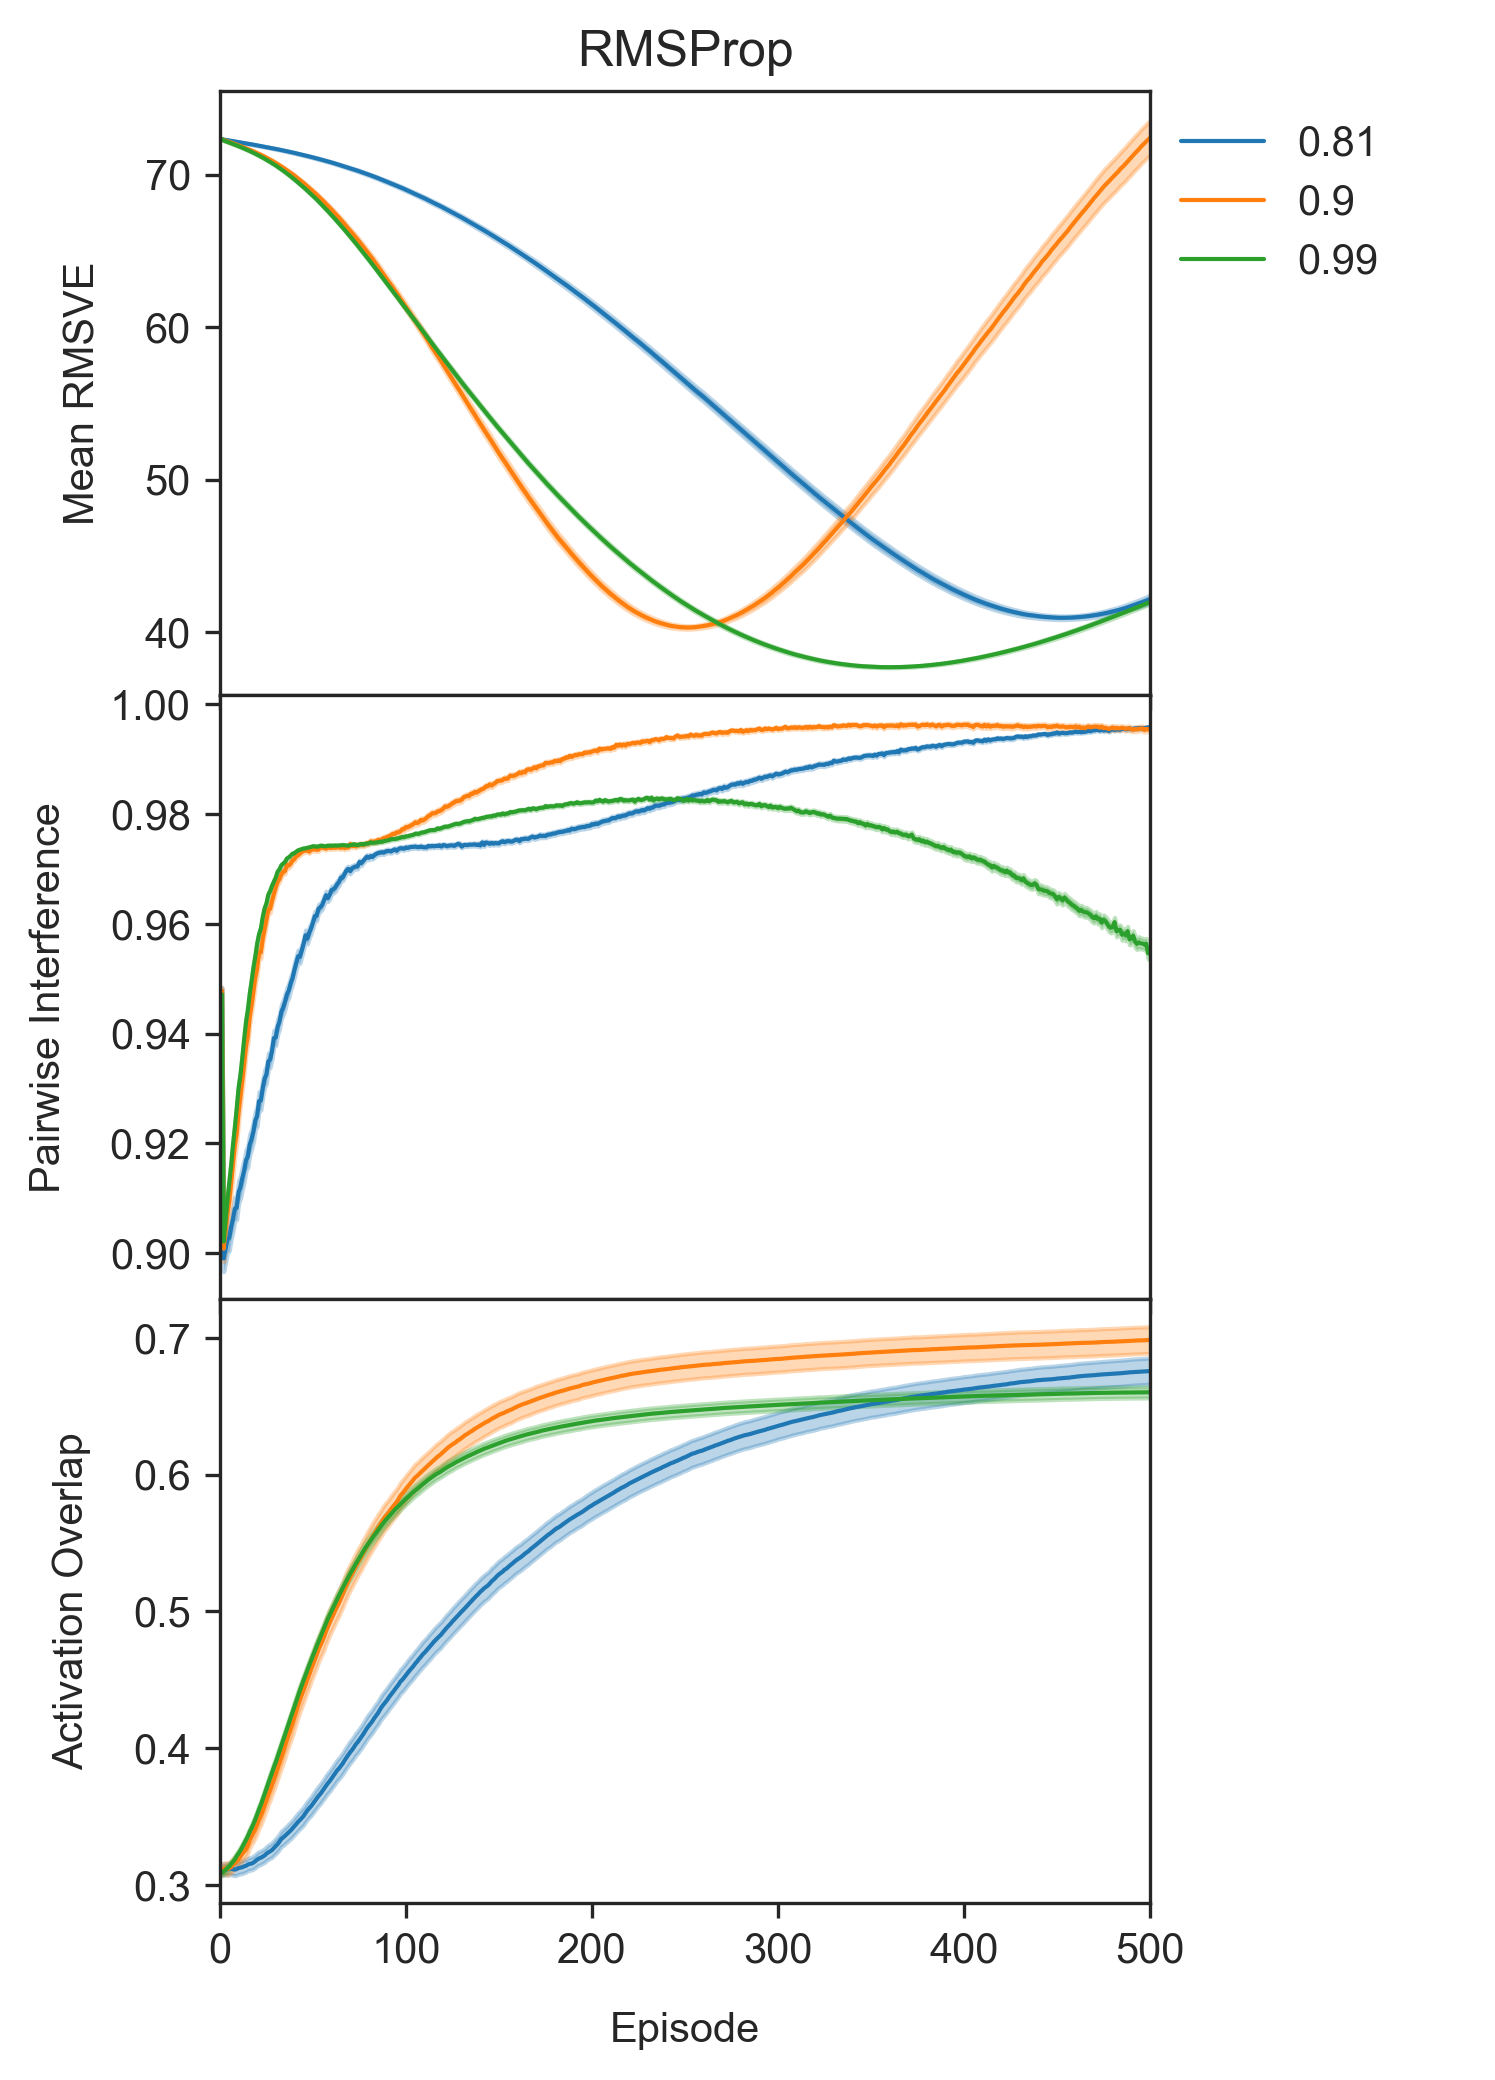

In [15]:
sns.set_style('ticks')
colors = sns.color_palette(n_colors=len(best_by_optimizer_summary.keys()))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, dpi=300, figsize=(4, 8))
sort_key = lambda x: '~' if x[0] == 'constant' else x[0]
for i, (optimizer, value) in enumerate(sorted(best_by_optimizer_summary.items(), key=sort_key)):
    y1 = value['accuracy_mean']
    y1err = value['accuracy_stderr']
    x = np.arange(len(y1)) + 1
    ax1.plot(
        x,
        y1,
        label=optimizer,
        linewidth=1,
        color=colors[i])
    ax1.fill_between(
        x,
        y1 - y1err,
        y1 + y1err,
        alpha=0.3,
        color=colors[i])
    try:
        y2 = value['pairwise_interference_mean']
        y2err = value['pairwise_interference_stderr']
        ax2.plot(
            x,
            y2,
            linewidth=1,
            color=colors[i])
        ax2.fill_between(
            x,
            y2 - y2err,
            y2 + y2err,
            alpha=0.3,
            color=colors[i])
    except KeyError:
        pass
    try:
        y3 = value['activation_overlap_mean']
        y3err = value['activation_overlap_stderr']
        ax3.plot(
            x,
            y3,
            linewidth=1,
            color=colors[i])
        ax3.fill_between(
            x,
            y3 - y3err,
            y3 + y3err,
            alpha=0.3,
            color=colors[i])
    except KeyError:
        pass
ax1.set_title('RMSProp')
ax1.set_ylabel('Mean RMSVE', labelpad=10)
ax2.set_ylabel('Pairwise Interference', labelpad=10)
ax3.set_ylabel('Activation Overlap', labelpad=10)
ax3.set_xlim(0, 500)
ax3.set_xlabel('Episode', labelpad=10)
fig.legend(loc='upper right', bbox_to_anchor=(1.18, 0.83), frameon=False)
fig.subplots_adjust(hspace=0.0)
fig.savefig('rms_results.png', bbox_inches='tight')